# BAB 1 - Perkenalan

Nama : Bagas Distyo Utomo

Batch : RMT-41

Problem Statement :
Memprediksi tren popularitas Pulau Pari berdasarkan data Google Trends untuk meningkatkan akurasi peramalan permintaan dan mendukung perencanaan promosi, dengan tujuan menghasilkan prediksi mingguan yang akurat selama 52 minggu ke depan menggunakan model time series, sehingga dapat membantu pengambilan keputusan yang berbasis data bagi perusahaan travel agent.


Objective :
Tujuan dari analisis ini adalah membangun model prediksi menggunakan pendekatan ARIMA dan SARIMA untuk memperkirakan popularitas Pulau Pari selama 52 minggu ke depan. Evaluasi performa model dilakukan menggunakan metrik MAE (Mean Absolute Error) dan MAPE (Mean Absolute Percentage Error), guna menilai tingkat akurasi prediksi dan menentukan model yang paling optimal dalam mendukung perencanaan pemasaran dan pengelolaan paket wisata ke Pulau Pari.


# BAB 2 - Import Libraries

Untuk semua library yang akan digunakan disimpan di bab ini.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

Selanjutnya melakukan data loading

# BAB 3 - Data Loading

In [31]:
#dataset load
df_ori = pd.read_csv('multiTimeline.csv')

#duplicat dataset
df = df_ori.copy() #Tujuan duplikat agar dataset asli tidak berubah ketika dibutuhkan suatu saat nanti
df.head(5)

,Category: All categories
Week,Pulau Pari: (Indonesia)
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29


Data sudah berhasil di load, selanjutnya melakukan eksplorasi data sederhana.

In [ ]:
# df.reset_index(inplace=True) #Mengubah kolom week menjadi kolom biasa untuk dianalisis

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, Week to 2024-08-18
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Category: All categories  127 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


Data tersebut berisi 127 baris dan untuk isi kolom categorynya object, seharusnya integer. Selanjutnya rename column agar lebih sesuai

In [32]:
# Renaming columns
df.rename(columns={'Category: All categories': 'Popularity'}, inplace=True)

Selanjutnya menghapus baris pertama karena berisi week dan pulau pari.

In [36]:
df.drop(df.index[0], inplace=True) #Menghapus baris pertama karena itu sebagai nama kolom

In [37]:
df.head(5)

,Popularity
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35


Data tersebut menjadi 126 baris dan untuk datenya itu menggunakan week atau mingguan berdasarkan penjelasan soal. Selanjutnya melakukan EDA

# BAB 4 - Exploratory Data Analysis (EDA)

Selanjutnya mengubah tipe data popularity menjadi integer

In [40]:
df['Popularity'] = df['Popularity'].astype(int) #Mengubah ke integer

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 2022-03-27 to 2024-08-18
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Popularity  126 non-null    int64
dtypes: int64(1)
memory usage: 2.0+ KB


Selanjutnya melihat apakah ada data mingguan yang tidak terisi atau terlewat

In [43]:
frequency = pd.infer_freq(df.index)
print(frequency)

W-SUN


Tidak ada data yang null, dan untuk frekuensinya itu mingguan. Selanjutnya melihat visualisasi data untuk melihat apakah data additive atau multiplicative

In [46]:
fig = px.line(df, x=df.index, y="Popularity", title='Total Popularity Pari Island')
fig.show()

Berdasarkan grafik tersebut, dapat dilihat bahwa secara tren mengalami penurunan dan penaikan yang signifikan pada setiap gelombang yang menunjukan bahwa data tersebut merupakan multiplicative. Dari data tersebut, terjadi 5 penaikan yang siginifikan yaitu pada 1 May 2022, 23 April 2023, 24 Desember 2023, 14 April 2024, dan 30 Jun 2024. Kenaikan angka terebut disebabkan karena hari libur yang membuat orang ingin mencari tahu mau liburan kemana

Selanjutnya melakukan Time Series Decomposition

## Time Series Decomposition

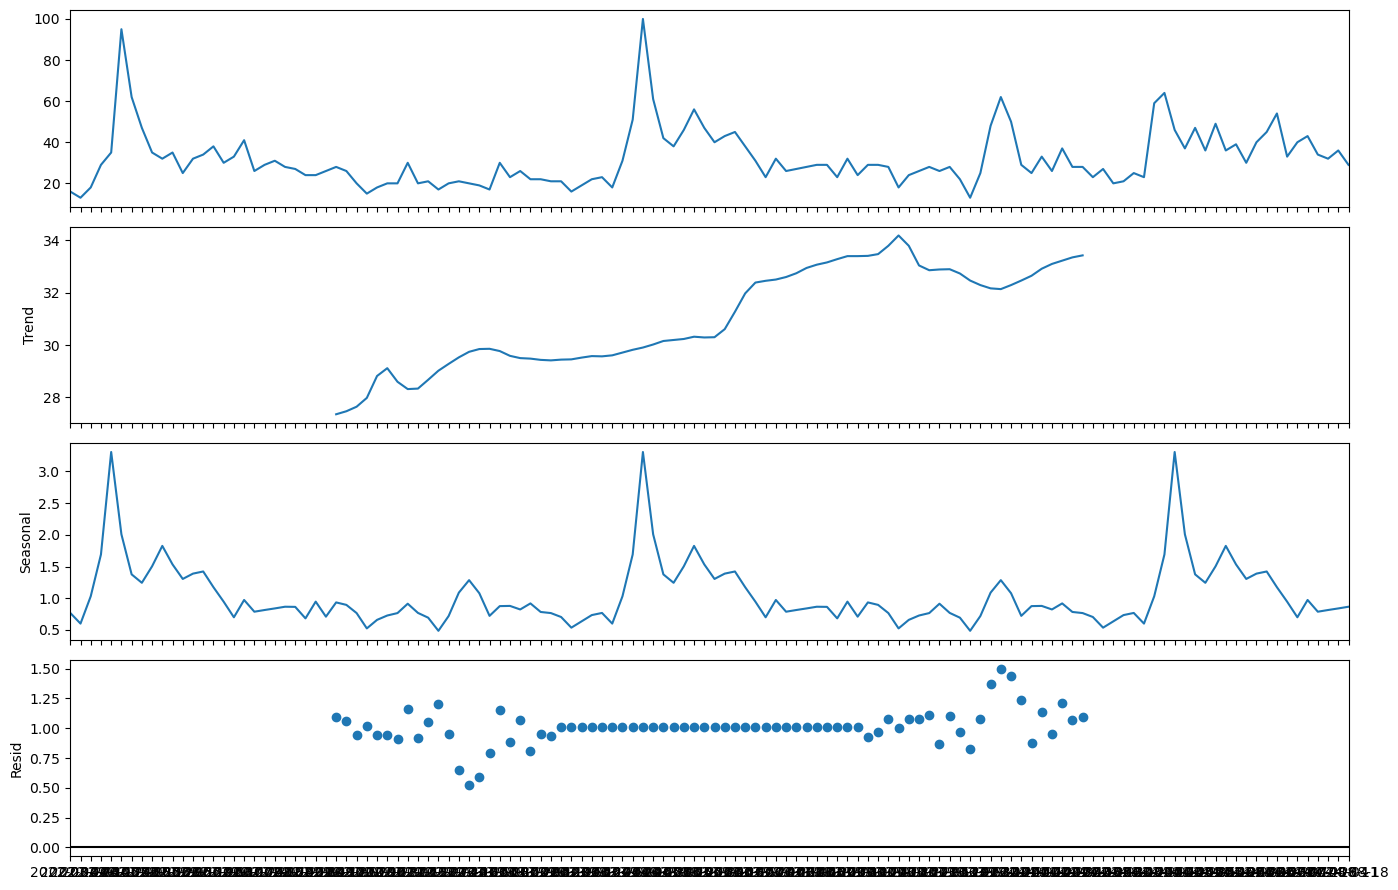

In [47]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df, model='multiplicative', period=52)
ax=res.plot()
plt.show()

Untuk period saya memakai 52 karena ingin melihat pola mingguan dalam tahunan pada data tersebut yang berarti dalam satu tahun ada 52 minggu. Berdasarkan gambar tersebut :
- Untuk tren dari tahun 2022 hingga 2024 mengalami peningkatan sebanyak 5 kali secara signifikan, dan untuk penurunannya tidak terlalu signifikan sehigga tidak terlalu terlihat.
- Untuk seasonal, terjadi beberapa peningkatan dalam waktu tertentu, dilihat dari visualisasi data sebelumnya, terjadi 5 penaikan yang siginifikan yaitu pada 1 May 2022, 23 April 2023 , 24 Desember 2023, 14 April 2024, dan 30 Juni 2024. Jika dilihat dari tanggal tersebut, tanggal tersebut merupakan tanggal merah atau tanggal dimana waktu liburan sehingga banyak orang yang ingin mencari tahu informasi tentang lokasi pariwisata.
- Untuk residu memiliki variansi yang tinggi karena beberapa titik titik di awal dan diakhir tidak saling berdekatan.

Selanjutnya melakukan splitting data

## Splitting Data

In [51]:
train = df[:100]
test = df[100:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (100, 1)
Test size :  (26, 1)


Jumlah data train 100 dan test 26. Selanjutnya melihat stationarity dengan menggunakan ADF

In [52]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [53]:
check_stationarity(train['Popularity'])

ADF Statistic: -3.470815
p-value: 0.008769
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Stationary


Data tersebut sudah stationer tanpa dilakukan differencing yang menunjukan bahwa pola pada data tersebut stabil. Selanjutnya melihat ACF dan PACF

## ACF & PACF

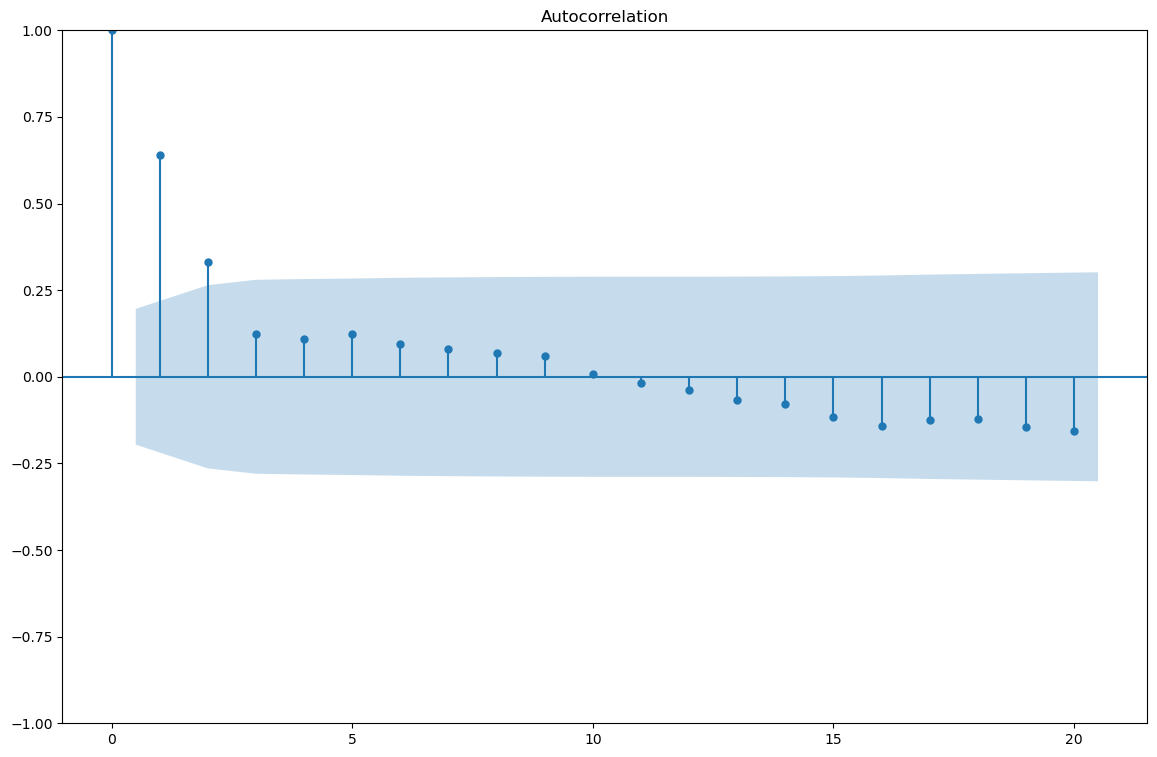

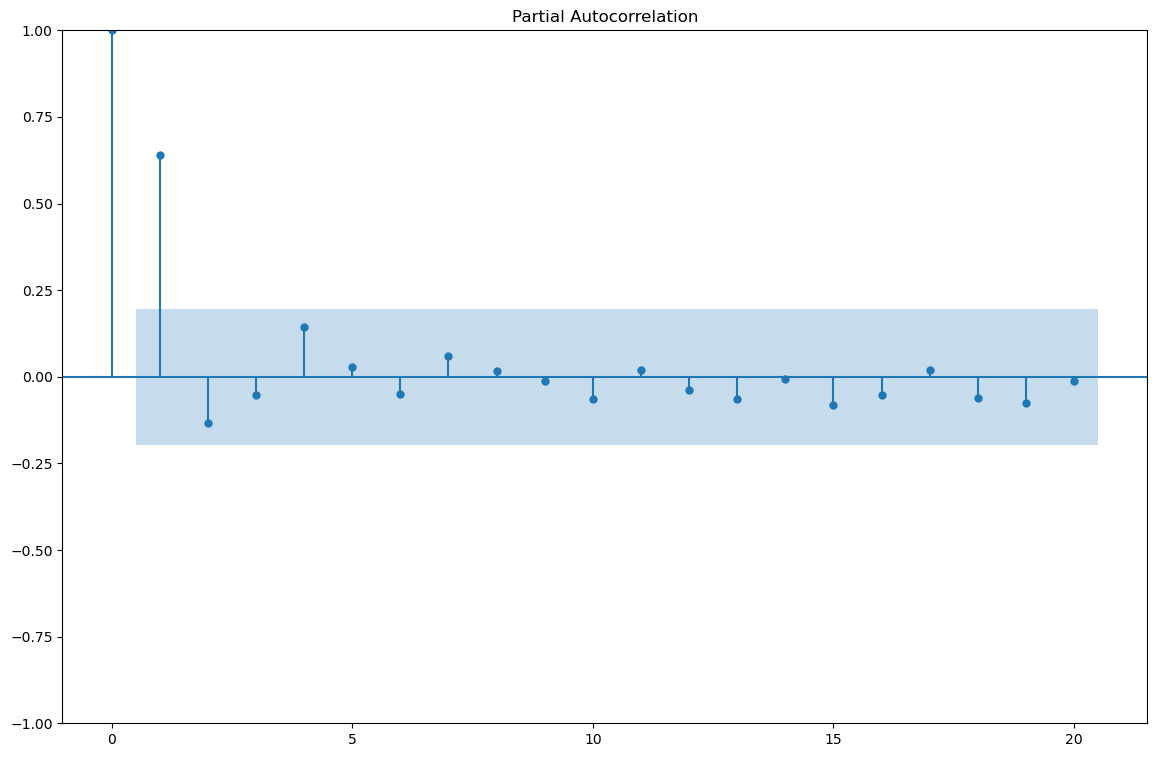

In [55]:
# Plot ACF & PACF
plot_acf(train['Popularity'])
plot_pacf(train['Popularity'])
plt.show()

- Untuk ACF (q) cut off di 1 dan 2. Setelahnya berada di confidence treshold.
- Untuk PACF (p) cut off di 1 dan setelahnya berada di confidence treshold.
- Sebelumnya tidak menggunakan differencing makan d nya adalah 0

Sehingga bisa dicoba menggunakan model (1,0,1) dan (1,0,2).

Selanjutnya mencari model mana yang optimal

## Find Best Model

In [56]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [58]:
# Find best model of ARIMA with combinations of p=1, d=0, q=2
find_best_model(train['Popularity'], 1, 0, 2) 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No

(0,
 0,
 2,
 765.5537411307513,
    p  d  q         AIC
 2  0  0  2  765.553741
 3  1  0  0  766.706935
 5  1  0  2  766.722890
 4  1  0  1  767.399345
 1  0  0  1  779.207928
 0  0  0  0  817.754552)

Dari hasil pencarian model yang optimal tersebut, yang memiliki nilai AIC paling kecil adalah 0,0,2. Sedangkan jika ingin menggunakan ARIMA dan SARIMA membutuhkan AR atau p dan MA atau q. Jika dilihat lagi, yang paling sesuai adalah 1,0,2 karena memiliki nilai yang terkecil dibanding 1,0,1

Setelah itu mendefine model dengan parameter 1,0,2

# BAB 5 - Model Definition and Training

In [59]:
# Train ARIMA with best combinations

model_arima_102 = ARIMA(train['Popularity'], order=(1, 0, 2))
result_model_arima_102 = model_arima_102.fit()

# Trai Sarima
sar=SARIMAX(train['Popularity'], order=(1, 0, 2),seasonal_order=(1, 0, 2, 52)).fit() #Untuk seasonal 52 karena ingin melihat pola mingguan dalam tahun

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91112D+00    |proj g|=  4.34481D-02


 This problem is unconstrained.



At iterate    5    f=  3.87712D+00    |proj g|=  1.17072D-01

At iterate   10    f=  3.87008D+00    |proj g|=  7.61657D-03

At iterate   15    f=  3.86685D+00    |proj g|=  1.34630D-03

At iterate   20    f=  3.86673D+00    |proj g|=  1.93547D-03

At iterate   25    f=  3.86581D+00    |proj g|=  6.08982D-03

At iterate   30    f=  3.86547D+00    |proj g|=  8.00650D-03

At iterate   35    f=  3.86519D+00    |proj g|=  5.49120D-03

At iterate   40    f=  3.86504D+00    |proj g|=  3.43431D-03

At iterate   45    f=  3.86501D+00    |proj g|=  1.02561D-03


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  3.86500D+00    |proj g|=  9.46334D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   9.463D-05   3.865D+00
  F =   3.8650015129171100     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Setelah train model selanjutnya evaluasi

# BAB 6 - Model Evaluation

Untuk evaluasi disini menggunakan MAE dan MAPE. Alasan menggunakan MAE karena mudah dipahami dan diinterpretasikan dan tidak terlalu sensitif terhadap outlier. Alasan menggunakan MAPE karena mudah dipahami juga dan ingin melihat persentase akurasi dari prediksi

### ARIMA

In [64]:
pred_train = result_model_arima_102.predict(start=train.index[0], end=train.index[-1])
pred_train = pd.DataFrame(pred_train)
pred_train.columns = ['Popularity_predict']

In [ ]:
print('MAE train  : ', mean_absolute_error(train, pred_train))
print('MAPE train  : ', mean_absolute_percentage_error(train, pred_train))

MAE train  :  6.69125920627734
MAPE train  :  0.21998321483469901


In [70]:
pred_test = result_model_arima_102.predict(start=test.index[0], end=test.index[-1])
mae = mean_absolute_error(test, pred_test)
mape = mean_absolute_percentage_error(test, pred_test)
print('MAE test : ', mae)
print('MAPE test : ', mape)

MAE test :  10.07469785796185
MAPE test :  0.24973687019083382


In [86]:
pred_train = pd.DataFrame(pred_train)
pred_train.columns = ['Popularity_predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([train, pred_train], axis=1)
act_vs_pred_sar

,Popularity,Popularity_predict
2022-03-27,16,30.455419
2022-04-03,13,21.258165
2022-04-10,18,19.836995
2022-04-17,29,24.387654
2022-04-24,35,32.004378
...,...,...
2024-01-21,33,26.309346
2024-01-28,26,34.714661
2024-02-04,37,27.249441
2024-02-11,28,33.923978


In [87]:
pred_test = pd.DataFrame(pred_test)
pred_test.columns = ['Total_Ticket_Sold_predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([test, pred_test], axis=1)
act_vs_pred_sar

,Popularity,Total_Ticket_Sold_predict
2024-02-25,23,26.776014
2024-03-03,27,28.986563
2024-03-10,20,30.168584
2024-03-17,21,30.399407
2024-03-24,25,30.444481
2024-03-31,23,30.453283
2024-04-07,59,30.455002
2024-04-14,64,30.455338
2024-04-21,46,30.455403
2024-04-28,37,30.455416


Untuk ARIMA, MAE train adalah 6.69 atau model kurang lebih salam memprediksi popularitas pulau pari sekitar 6 angka. MAPE train menunjukan 0.21 yang artinya prediksi model meleset sebesar 21% dari aktual.

Lalu untuk train, MAE menunjukan angka 10 yang artinya model meleset dalam memprediksi sebesar 10 angka dan untuk MAPE menunjukan angka 0.24 yang artinya prediksi model meleset sebesar 24% dari aktual.

Selanjutnya melihat visualisasinya

In [74]:
print(type(train.index))

<class 'pandas.core.indexes.base.Index'>


In [ ]:
train.index = pd.to_datetime(train.index) #Mengubah index ke datetime
test.index = pd.to_datetime(test.index)
pred_test.index = pd.to_datetime(pred_test.index)

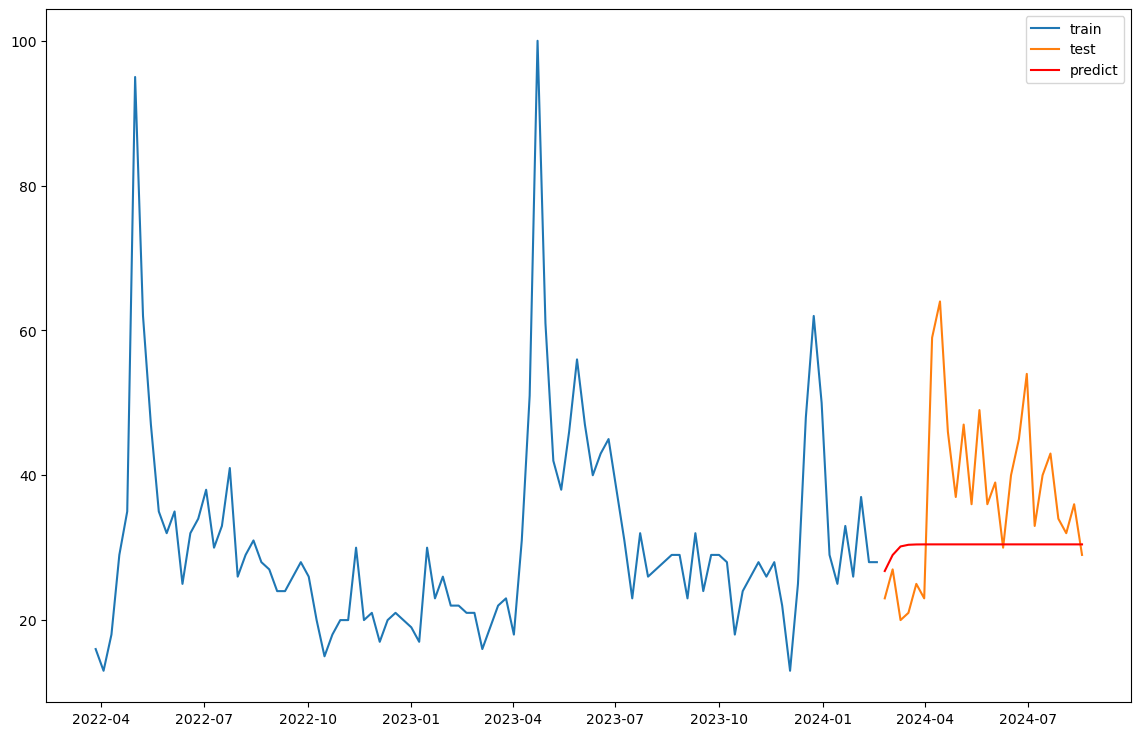

In [76]:
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(pred_test, color = 'red', label = 'predict')
plt.legend()
plt.show()

Gambar tersebut merupakan prediksi dari data menggunakan ARIMA, terlihat untuk prediksinya itu garis lurus, tidak mengikuti pola musiman.

Selanjutnya evaluasi untuk SARIMA

### SARIMA

In [77]:
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Popularity   No. Observations:                  100
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 52)   Log Likelihood                -386.500
Date:                            Mon, 21 Apr 2025   AIC                            787.000
Time:                                    11:37:00   BIC                            805.236
Sample:                                03-27-2022   HQIC                           794.381
                                     - 02-18-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9837      0.038     26.105      0.000       0.910       1.058
ma.L1         -0.2663      0.154     -1.724      0.085      -0.569       0.036
ma.L2         -0.3031      0.210     -1.446      0.148      -0.714       0.108
ar.S.L52       0.8658    317.196      0.003      0.998    -620.827     622.558
ma.S.L52      -1.4178    572.337     -0.002      0.998   -1123.178    1120.342
ma.S.L104      0.9576    203.851      0.005      0.996    -398.583     400.498
sigma2        58.7111     32.694      1.796      0.073      -5.368     122.790
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):              1202.54
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             3.33
Prob(H) (two-sided):                  0.01   Kurtosis:                        18.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.36e+18. Standard errors may be unstable.
"""

In [81]:
sar_pred_train = sar.predict(start=train.index[0], end=train.index[-1])
sar_pred_train = pd.DataFrame(sar_pred_train)
sar_pred_train.columns = ['Popularity_predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([train, sar_pred_train], axis=1)
act_vs_pred_sar

,Popularity,Popularity_predict
2022-03-27,16,0.000000
2022-04-03,13,14.798429
2022-04-10,18,12.535902
2022-04-17,29,17.063889
2022-04-24,35,24.204137
...,...,...
2024-01-21,33,30.471386
2024-01-28,26,33.878281
2024-02-04,37,27.196652
2024-02-11,28,36.308806


In [82]:
print('MAE train  : ', mean_absolute_error(train, sar_pred_train))
print('MAPE train  : ', mean_absolute_percentage_error(train, sar_pred_train))

MAE train  :  6.511971850918965
MAPE train  :  0.1972276636463336


In [83]:
# Predict test-set

## Predict test-set
sar_pred_test = sar.predict(start=test.index[0], end=test.index[-1])
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['Popularity']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar

,Popularity,Popularity
2024-02-25,23,30.038367
2024-03-03,27,29.515301
2024-03-10,20,29.226118
2024-03-17,21,27.891629
2024-03-24,25,24.997037
2024-03-31,23,23.527733
2024-04-07,59,25.341572
2024-04-14,64,29.655077
2024-04-21,46,31.700681
2024-04-28,37,57.043933


In [84]:
print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('MAPE test  : ', mean_absolute_percentage_error(test, sar_pred_test))

MAE test  :  10.345123014901628
MAPE test  :  0.25299275871208354


Untuk SARIMA, pada hasil train menunjukan angka MAE sebesar 6.5 yang menunjukan bahwa model meleset dalam memprediksi kurang lebih 6 angka dan angka MAPE menunjukan 0.19 yang menunjukan bahwa model meleset 19% dalam memprediksi.

Lalu untuk test, menunjukan angka 10.3 yang menunjukan bahwa model meleset dalam memprediksi kurang lebih 10 angka dan angka MAPE menunjukan 0.25 yang menunjukan bahwa model meleset 25% dalam memprediksi.

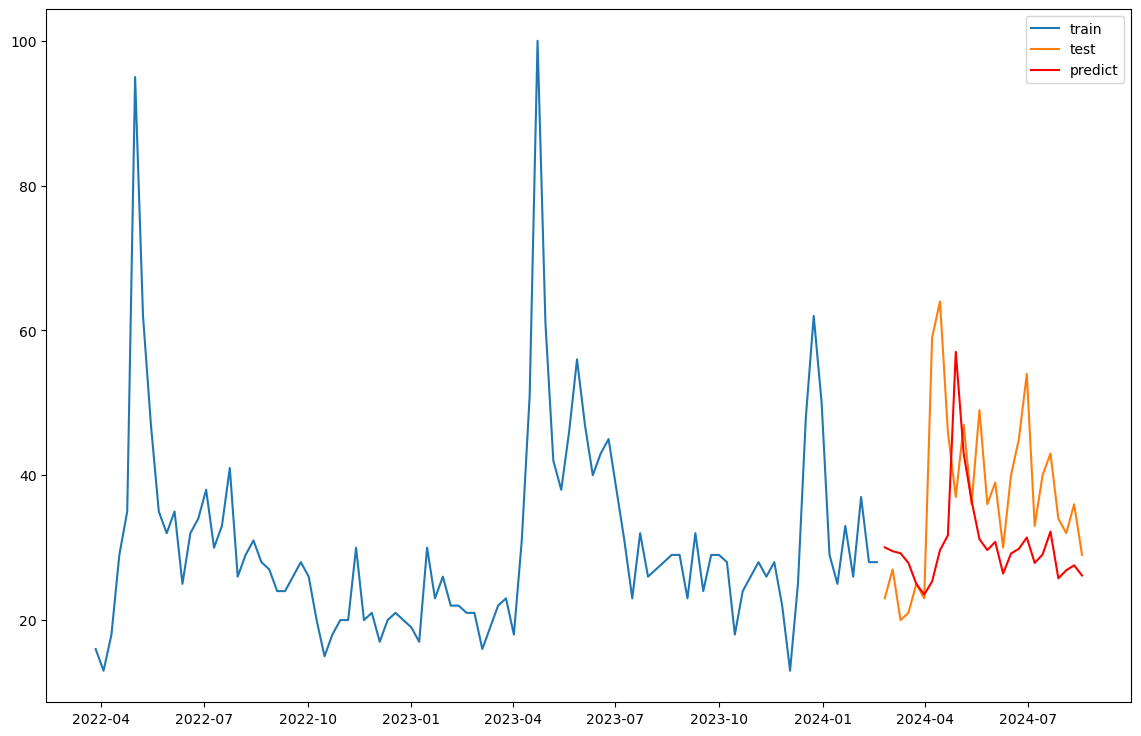

In [85]:
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(sar_pred_test, color = 'red', label = 'predict')
plt.legend()
plt.show()

Garis yang merah merupakan prediksi dari popularity data tersebut. Bentuknya mengikuti pola seasonal.

Perbandingan :

ARIMA :

TRAIN

- MAE : 6.69

- MAPE : 0.21

TEST

- MAE : 10

- MAPE : 0.24

SARIMA :

TRAIN

- MAE : 6.5

- MAPE : 0.19

TEST

- MAE : 10.3

- MAPE : 0.25

Jika dilihat dari perbandingan data tersebut, nilai test MAE dan MAPE pada ARIMA lebih kecil daripada SARIMA yang menunjukan bahwa error pada ARIMA lebih sedikit dibanding SARIMA sehingga ARIMA merupakan model yang terbaik walaupun hasil prediksi SARIMA garisnya mengikuti pola seasonal

# BAB 7 - Inference

Setelah menentukan model mana yang terbaik, selanjutnya inference ARIMA selama satu tahun kedepan yang berarti 52 minggu

In [88]:
# Predict next 52 weeks

len_dataset = df.shape[0]
len_predict = len_dataset + 52

new_pred = result_model_arima_102.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns=['Popularity_Predict']
all_dataset_with_pred = pd.concat([df, new_pred], axis=0)

In [89]:
# Original dataset

test.tail(5)

,Popularity
2024-07-21,43
2024-07-28,34
2024-08-04,32
2024-08-11,36
2024-08-18,29


In [90]:
# Prediction of next 52 Weeks

new_pred

,Popularity_Predict
2024-08-25,30.455419
2024-09-01,30.455419
2024-09-08,30.455419
2024-09-15,30.455419
2024-09-22,30.455419
2024-09-29,30.455419
2024-10-06,30.455419
2024-10-13,30.455419
2024-10-20,30.455419
2024-10-27,30.455419


Hasil prediksi menunjukan angka 30.455419 yang artinya model memprediksi popularitas pulau pari adalah 30 persen atau kurang populer

# BAB 8 - Kesimpulan

- Berdasarkan hasil EDA, data menunjukkan pola multiplicative dengan tren peningkatan dari tahun 2022 hingga 2024, ditandai oleh lima lonjakan signifikan yang terjadi pada momen-momen libur nasional, seperti 1 Mei 2022, 23 April 2023, 24 Desember 2023, 14 April 2024, dan 30 Juni 2024. Lonjakan ini mencerminkan peningkatan minat masyarakat untuk mencari informasi wisata saat hari libur. Sementara itu, komponen residu menunjukkan variansi yang tinggi, terutama di awal dan akhir data, mengindikasikan adanya fluktuasi yang tidak dapat dijelaskan oleh tren atau musiman
- Berdasarkan hasil evaluasi, model ARIMA dan SARIMA memiliki performa yang cukup mirip dalam memprediksi popularitas Pulau Pari. ARIMA menunjukkan MAE sebesar 6.69 dan MAPE 21% pada data latih, serta MAE 10 dan MAPE 24% pada data uji. Sementara itu, SARIMA dengan MAE 6.5 dan MAPE 19% pada data latih, serta MAE 10.3 dan MAPE 25% pada data uji. Jika dilihat dari perbandingan data tersebut, nilai test MAE dan MAPE pada ARIMA lebih kecil daripada SARIMA yang menunjukan bahwa error pada ARIMA lebih sedikit dibanding SARIMA sehingga ARIMA merupakan model yang terbaik walaupun hasil prediksi SARIMA garisnya mengikuti pola seasonal
- Kelebihan ARIMA adalah mampu memprediksi sedikit lebih baik dibanding dengan ARIMA, namun untuk kelemahnnya tidak bisa menerima pola musiman sehingga hasil prediksinya konstan.